In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np;
import pandas as pd;
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
import re

from adjustText import adjust_text
from scipy import special, optimize
from sklearn.linear_model import LinearRegression

---
---
# Injection Moulding

In [2]:
def get_csv(filename, headDrop, tailDrop):
    df = pd.read_csv(filename, header=None, sep='\n');

    # Remove file header (1st 11 rows)
    r = 11;
    for i in range(r):
        df = df.drop([i]);

    # Split columns by commas
    df = df[0].str.split(",", expand=True);

    new_header = df.iloc[0]; #grab the first row for the header
    df = df[1:]; #take the data less the header row
    df.columns = new_header; #set the header row as the df header

    units = df.iloc[0]; # Get units
    df = df.drop([r+1]); # Remove units row from dataframe
    
    df.drop(df.head(headDrop).index, inplace=True) # drop first headDrop rows
    df.drop(df.tail(tailDrop).index, inplace=True) # drop last tailDrop rows
    '''
    if headDrop > 0:
        for i in range(headDrop):
            df = df.drop([r+2+i]);
            
    if tailDrop > 0:
        for i in range(tailDrop):
            df = df.drop([len(df)]);
    '''

    #      [0]    [1]
    return units, df;

### Cross
### $$ \frac{\eta - b}{a - b} = \frac{1}{1 + (c \dot{\gamma})^d} $$
### $$ \eta = \frac{a - b}{1 + (c \dot{\gamma})^d} + b $$

### where:
$a =$ zero rate viscosity <br>
$b =$ infinite rate viscosity <br>
$c =$ consistency <br>
$d =$ rate index

In [3]:
def Cross_(gamma, eta_zero, eta_inft, kappa, n):
    a = eta_zero;
    b = eta_inft;
    c = kappa;
    d = n;
    
    nume = a - b;
    deno = 1 + (c*gamma)**d;
    
    return (nume/deno) + b;

### Carreau
### $$ \frac{\eta - b}{a - b} = \left[1 + \left(c \dot{\gamma}\right)^2\right]^{\frac{d - 1}{2}} $$
### $$ \eta = \frac{a - b}{\left[1 + \left(c \dot{\gamma}\right)^2\right]^{\frac{1 - d}{2}}} + b $$

### where:
$a =$ zero rate viscosity <br>
$b =$ infinite rate viscosity <br>
$c =$ consistency <br>
$d =$ rate index

In [4]:
def Carreau_(gamma, eta_zero, eta_inft, kappa, n):
    a = eta_zero;
    b = eta_inft;
    c = kappa;
    d = n;
    
    nume = a - b;
    
    base = 1 + (c*gamma)**2;
    expo = (1 - d)/2;
    deno = base**expo;
    
    return (nume/deno) + b;

### The Carreau-Yasuda Model [1]
### $$ \frac{\eta - b}{a - b} = \frac{1}{\left[1 + \left(c \dot{\gamma}\right)^e\right]^{\frac{1 - d}{e}}} $$
### $$ \frac{\eta - \eta_{\infty}}{\eta_0 - \eta_{\infty}} = \frac{1}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} $$
### $$ \eta = \frac{\eta_0 - \eta_{\infty}}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} + \eta_{\infty} $$

### where:
$\eta =$ Viscosity <br>
$\dot{\gamma} =$ Shear rate <br>
$\eta_{\infty} =$ Infinite shear rate viscosity <br>
$\eta_0 =$ Zero shear rate viscosity <br>
$\kappa =$ Time constant <br>
$n =$ The Power Law index <br>
$a =$ The width of the transition region between the zero shear viscosity and the Power Law region

#### [1] Osswald, T., Rudolph, N., Osswald, T., & Rudolph, N. (2014). Generalized Newtonian Fluid (GNF) Models. Polymer Rheology, 59–99. https://doi.org/10.3139/9781569905234.003

In [5]:
def CarreauYasuda_(gamma, eta_zero, eta_inft, kappa, n, m):
    a = eta_zero;
    b = eta_inft;
    c = kappa;
    d = n;
    e = m;
    
    nume = a - b;
    
    base = 1 + (c*gamma)**e;
    expo = (1 - d)/e;
    deno = base**expo;
    
    return (nume/deno) + b;

### Sisko
### $$ \eta = a + b \dot{\gamma}^{c - 1} $$

### where:
$a =$ infinite rate viscosity <br>
$b =$ consistency <br>
$c =$ rate index

In [6]:
def sisko_(gamma, eta_inft, kappa, n):
    a = eta_inft;
    b = kappa;
    c = n;
    
    expo = c - 1;
    
    return a + b*(gamma**expo);

### Williamson
### $$ \eta = \frac{a}{1 + (b \dot{\gamma})^c} $$

### where:
$a =$ zero rate viscosity <br>
$b =$ consistency <br>
$c =$ rate index

In [7]:
def williamson_(gamma, eta_zero, kappa, n):
    a = eta_zero;
    b = kappa;
    c = n;
    
    deno = 1 + (b*gamma)**c;
    
    return a/deno;

### Power Law
### $$ \eta = m \dot{\gamma}^n $$

### where:
$\eta =$ viscosity <br>
$m =$ Consistency index <br>
$n =$ Power Law index

In [8]:
def powerLaw_(gamma, m, n):
    b = m;
    c = n;
    
    res = b * gamma**(c-1);
    
    return res;

---
### Best Fit

In [9]:
def fit_Model_(filename, headDrop, tailDrop, plotname, modelName, eta_zero=0, eta_inft=0, kappa=0, n=0, m=0):
    # get units and Data
    units_df = get_csv(filename, headDrop, tailDrop)[0]
    nSeal_df = get_csv(filename, headDrop, tailDrop)[1]

    # Chose what to plot
    x_index = 1; # gamma = Shear rate
    y_index = 2; # eta   = Viscosity

    # Optimization process
    gamma = nSeal_df.iloc[:, x_index].to_numpy().astype(np.float);
    eta   = nSeal_df.iloc[:, y_index].to_numpy().astype(np.float);

    # remove neg values
    gamma = gamma[eta >= 0]
    eta = eta[eta >= 0]

    # Optimize according to the selected modelName
    if modelName == 'Cross':
        p0 = eta_zero, eta_inft, kappa, n;
        eta_fit = Cross_(gamma, eta_zero, eta_inft, kappa, n);
    
    elif modelName == 'Carreau':
        p0 = eta_zero, eta_inft, kappa, n;
        eta_fit = Carreau_(gamma, eta_zero, eta_inft, kappa, n);
    
    elif modelName == 'CarreauYasuda':
        p0 = eta_zero, eta_inft, kappa, n, m;
        eta_fit = CarreauYasuda_(gamma, eta_zero, eta_inft, kappa, n, m);
    
    elif modelName == 'Sisko':
        p0 = eta_inft, kappa, n;
        eta_fit = sisko_(gamma, eta_inft, kappa, n);
    
    elif modelName == 'Williamson':
        p0 = eta_zero, kappa, n;
        eta_fit = williamson_(gamma, eta_zero, kappa, n);
        
    elif modelName == 'PowerLaw':
        p0 = eta_zero, n;
        eta_fit = powerLaw_(gamma, m, n)
    
    else:
        return "modelName shall take a valid value. Use help(fit_Model_) for more details.s"; 

    return gamma, eta_fit, eta_zero, eta_inft

In [10]:
def compareData_wFits_(plotname, filemanes, headDrop, tailDrop, plotlabels, Model, eta_zero, eta_inft, kappa, n, m, plotDatapoints=True, plotModel=True):
    
    # Get units
    units_df = get_csv(filemanes[0], headDrop[0], tailDrop[0])[0]
    display(units_df)

    # Draw plot canvas
    scale = 6;
    plt.subplots(figsize=(3*scale, 2*scale));
    ax0 = plt.gca()

    # Chose what to plot
    x_index = 1
    y_index = 2

    # Plot
    for i in range(len(filemanes)):
        y_fit = fit_Model_(
            fileNames[i],
            headDrops[i],
            tailDrops[i],
            fileDescription[i] + " - " + fileNames[i],
            Model[i],
            eta_zero[i],
            eta_inft[i],
            kappa[i],
            n[i],
            m[i]
        );
        
        _0_ps_thf_df = get_csv(filemanes[i], headDrop[i], tailDrop[i])[1]
        x = _0_ps_thf_df.iloc[:, x_index].to_numpy().astype(np.float)
        y = _0_ps_thf_df.iloc[:, y_index].to_numpy().astype(np.float)

        if plotDatapoints: plt.scatter(x, y, s=25);
        # s=(i*4)+2

        if plotModel:
            if Model[i] == 'Sisko':
                plt.plot(y_fit[0], y_fit[1], linewidth=2,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_{\infty} = $' + str(round(y_fit[3], 4)) + r' $Pa \cdot s$' + ';');
            elif Model[i] == 'Williamson':
                plt.plot(y_fit[0], y_fit[1], linewidth=2,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_0 = $' + str(round(y_fit[2], 4)) + r' $Pa \cdot s$' + ';');
            elif Model[i] == 'PowerLaw':
                plt.plot(y_fit[0], y_fit[1], linewidth=2,
                         label=plotlabels[i] + '; ' +
                         r'$m = $' + str(round(y_fit[2], 4)) + r' $Pa \cdot s$' + '; ' +
                         r'$n = $' + str(round(n[i], 4)) + ';');
            else:
                plt.plot(y_fit[0], y_fit[1], linewidth=2,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_0 = $' + str(round(y_fit[2], 4)) + r' $Pa \cdot s$' + '; ' +
                         r'$\eta_{\infty} = $' + str(round(y_fit[3], 4)) + r' $Pa \cdot s$' + ';');
    
    ax0.tick_params(which='both', direction='in', width=2,
                    bottom=True, top=True,
                    left=True, right=True);

    # Display plots
    plt.yscale('log');
    plt.xscale('log');
    plt.xlabel(str(_0_ps_thf_df.columns[x_index]) + " [" + str(units_df[x_index]) + "]", fontsize=24);
    plt.ylabel(str(_0_ps_thf_df.columns[y_index]) + " [" + str(units_df[y_index]) + "]", fontsize=24);
    plt.title(plotname, size=24);
    plt.legend(prop={'size': 18});
    plt.savefig('plt_' + re.sub('[^A-Za-z0-9]+', '', plotname) + '.png', dpi=300, bbox_inches='tight');
    display(plt);

---
### PPVIS 2020 - PAR0, PAR3, PAR5

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

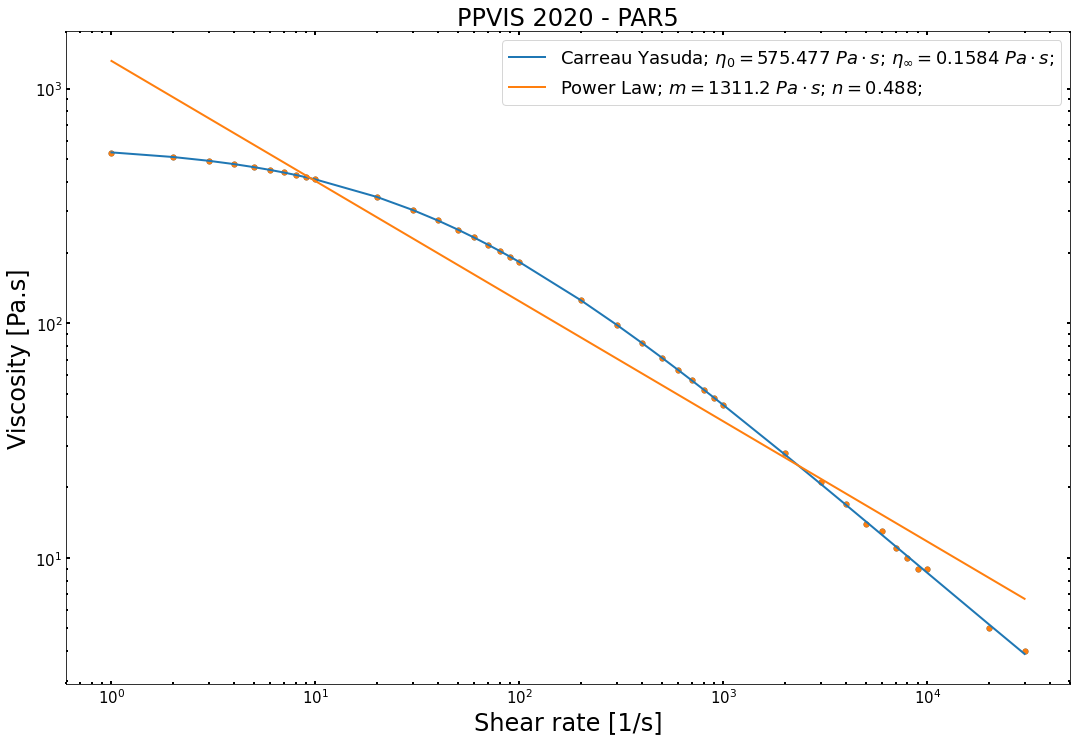

In [11]:
plotName        = "PPVIS 2020 - PAR5";
fileNames       = ["./midTerm_par5.csv", "./midTerm_par5.csv"];
Model           = [     'CarreauYasuda',           'PowerLaw'];
eta_zero        = [             575.477,              1311.20];
eta_inft        = [            0.158429,                 None];
kappa           = [           0.0259115,                 None];
n               = [            0.244547,             0.487996];
m               = [            0.716978,              1311.20];
fileDescription = [    "Carreau Yasuda",          "Power Law"];
headDrops       = [                   0,                    0];
tailDrops       = [                   0,                    0];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m);

---
---
# Capillary rheometer

In [12]:
# I'm multiplying by 0.0254 to convert inches to meters

# Convert Load into Pressure
def _load_2_pressure(load, L):
    diameter = 0.05*0.0254; #in - Capillary diameter
    radius = diameter/2;
    area = 2 * np.pi * radius * L; #L is the Die Length
    pressure = load/area;
    return pressure;

# Flow Rate Q
def _Q(Velocidad):
    diameter = 0.68; #cm - Barrel diameter
    diameter = 0.0068 #0.05; #in
    radius = diameter/2;
    area = np.pi * radius**2;
    Q = Velocidad*area;
    return Q

# Apparent Shear Rate Gamma
def _Gamma(Q, radius):
    Gamma = (4 * Q) / (np.pi * (radius*0.0254)**3)
    return Gamma

# Apparent Shear Stress tau_w
def _tau_w(load, L):
    tau_w = _load_2_pressure(load, L*0.0254)
    return tau_w

# Shear viscosity (used for apparent eta_A & corrected eta)
def _eta_A(tau_w, Gamma):
    eta_A = tau_w/Gamma
    return eta_A;

# Corrected Shear Rate Gamma
def _gamma_dot(Gamma, b):
    Gamma = ((3 + b) / 4) * Gamma
    return Gamma

In [13]:
Velocidad    = pd.Series([0.061, 0.061, 0.307, 0.307, 0.614, 0.614,  3.07,  6.14,  6.14,  13.8,   18.4]); #(in/s)
avgLoad_LD40 = pd.Series([170.3, 171.7, 420.5, 417.5, 579.1, 575.8, 848.4, 626.8, 623.6, 939.4, 1098.4]); #lbf
avgLoad_LD20 = pd.Series([ 92.6,  92.6, 216.9, 214.4, 296.5, 294.1, 390.7, 360.6, 377.8, 552.4,  640.3]); #lbf
avgLoad_LD10 = pd.Series([ 55.9,  54.1, 121.3, 119.4, 164.6, 162.9, 261.6, 233.8, 264.3, 368.5,  418.0]); #lbf
LD40 = pd.Series(np.full((1, 11), 40)[0]);
LD20 = pd.Series(np.full((1, 11), 20)[0]);
LD10 = pd.Series(np.full((1, 11), 10)[0]);

# Flow rate
Q = _Q(Velocidad);

# Apparent shear rate
Gamma = _Gamma(Q, 0.05/2);

# Apparent shear stress for each L/D value
tau_w_LD40 = _tau_w(avgLoad_LD40, 2);
tau_w_LD20 = _tau_w(avgLoad_LD20, 1);
tau_w_LD10 = _tau_w(avgLoad_LD10, 0.5);

# Apparent shear viscosity for each L/D value
eta_A_LD40 = _eta_A(tau_w_LD40, Gamma);
eta_A_LD20 = _eta_A(tau_w_LD20, Gamma);
eta_A_LD10 = _eta_A(tau_w_LD10, Gamma);

# Calculate slope b for Rabinowitch correction for each L/D value
model_LD40 = LinearRegression().fit(np.array(tau_w_LD40).reshape((-1, 1)), np.array(eta_A_LD40));
model_LD20 = LinearRegression().fit(np.array(tau_w_LD20).reshape((-1, 1)), np.array(eta_A_LD40));
model_LD10 = LinearRegression().fit(np.array(tau_w_LD10).reshape((-1, 1)), np.array(eta_A_LD40));

---
## Bagley Correction:
### getting pressure entrance effects by extrapolation

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

0      17.05
1      14.55
2      19.50
3      17.85
4      23.30
5      22.05
6      32.75
7     100.70
8     141.40
9     175.00
10    188.95
dtype: float64


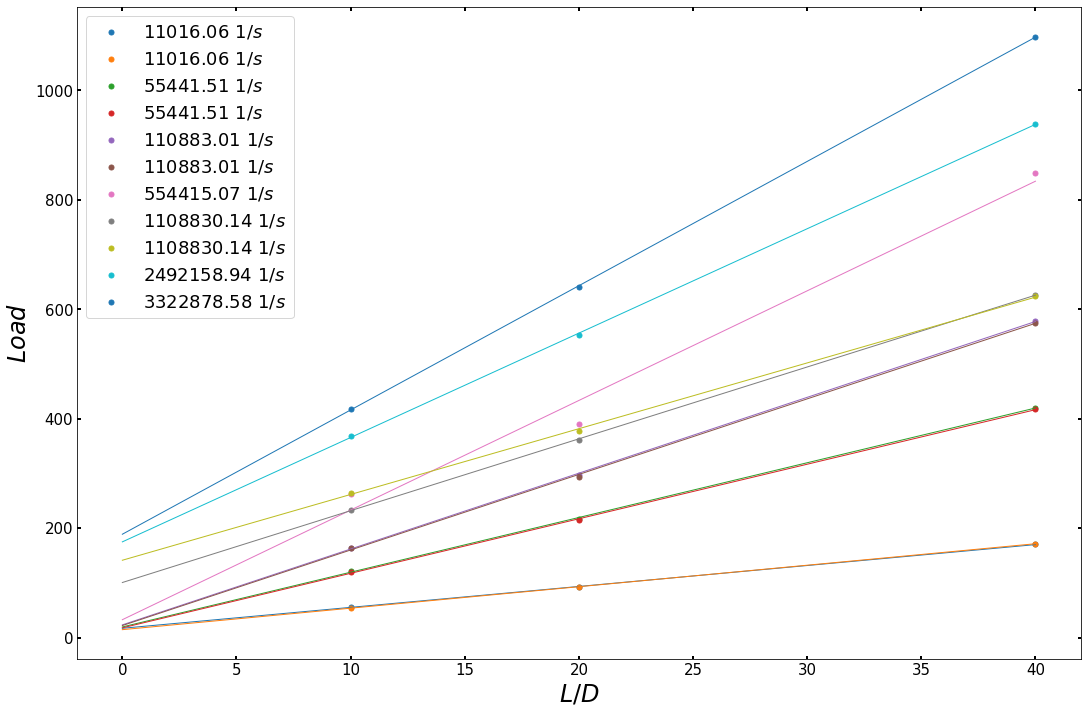

In [14]:
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()

entrancePressure = []; 
for i in range(len(avgLoad_LD40)):
    x = [LD40[i], LD20[i], LD10[i]];
    y = [avgLoad_LD40[i], avgLoad_LD20[i], avgLoad_LD10[i]];
    plt.scatter(x, y, s=25, label=str(round(Gamma[i], 2)) + ' ' + r'$1/s$');
    
    model = LinearRegression().fit(np.array(x).reshape((-1, 1)), np.array(y));
    x = x + [0];
    y = model.predict(np.array(x).reshape(-1, 1));
    plt.plot(x, y, linewidth=1);
    
    entrancePressure = entrancePressure + [model.intercept_];
entrancePressure = pd.Series(entrancePressure)
    
ax0.tick_params(which='both', direction='in', width=2,
                bottom=True, top=True,
                left=True, right=True);

# Display plots
plt.yscale('linear');
plt.xscale('linear');
plt.xlabel(r'$L/D$', fontsize=24);
plt.ylabel(r'$Load$', fontsize=24);
# plt.title(plotname, size=24);
plt.legend(prop={'size': 18});
plt.savefig('plt_' + "Capillary rheometer correction" + '.png', dpi=300, bbox_inches='tight');
display(plt);

print(entrancePressure)

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

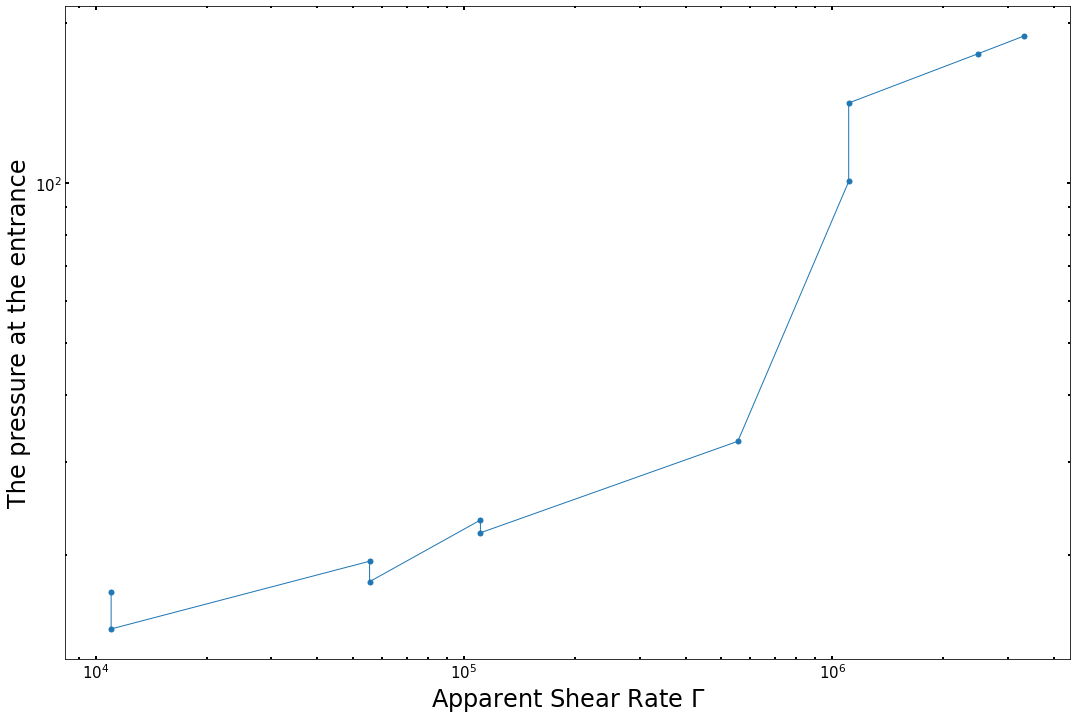

In [15]:
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()

plt.scatter(Gamma, entrancePressure, s=25);
plt.plot(Gamma, entrancePressure, linewidth=1);
    
ax0.tick_params(which='both', direction='in', width=2,
                bottom=True, top=True,
                left=True, right=True);

# Display plots
plt.yscale('log');
plt.xscale('log');
plt.xlabel("Apparent Shear Rate " + r'$\Gamma$', fontsize=24);
plt.ylabel("The pressure at the entrance", fontsize=24);
# plt.title(plotname, size=24);
# plt.legend(prop={'size': 18});
plt.savefig('plt_' + "Capillary rheometer correction" + '.png', dpi=300, bbox_inches='tight');
display(plt);

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

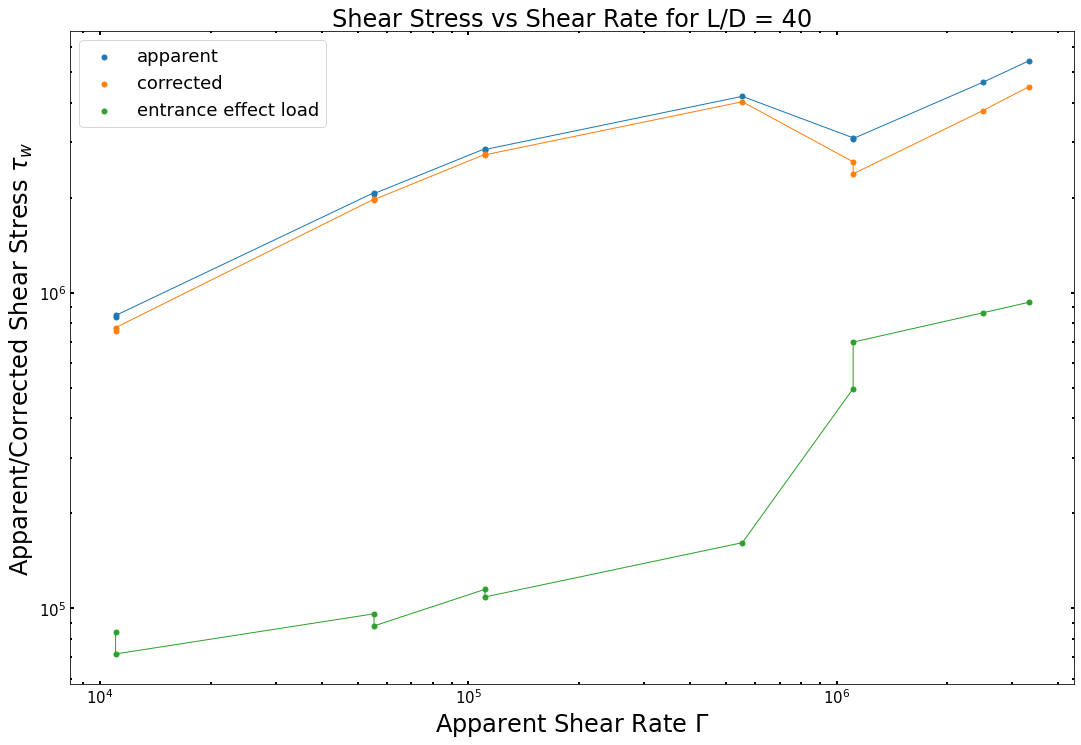

In [16]:
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()

tau_LD40 = _tau_w(avgLoad_LD40 - entrancePressure, 2);

plt.scatter(Gamma, tau_w_LD40,                  s=25, label="apparent", linestyle='-');
plt.scatter(Gamma, tau_LD40,                    s=25, label="corrected", linestyle='-');
plt.scatter(Gamma, _tau_w(entrancePressure, 2), s=25, label="entrance effect load", linestyle='-');

plt.plot(Gamma, tau_w_LD40,                  linewidth=1);
plt.plot(Gamma, tau_LD40,                    linewidth=1);
plt.plot(Gamma, _tau_w(entrancePressure, 2), linewidth=1);

ax0.tick_params(which='both', direction='in', width=2,
                bottom=True, top=True,
                left=True, right=True);

# Display plots
plt.yscale('log');
plt.xscale('log');
plt.xlabel("Apparent Shear Rate " + r'$\Gamma$', fontsize=24);
plt.ylabel("Apparent/Corrected Shear Stress " + r'$\tau_w$', fontsize=24);
plt.title("Shear Stress vs Shear Rate for L/D = 40", size=24);
plt.legend(prop={'size': 18});
plt.savefig('plt_' + "Capillary rheometer correction" + '.png', dpi=300, bbox_inches='tight');
display(plt);

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

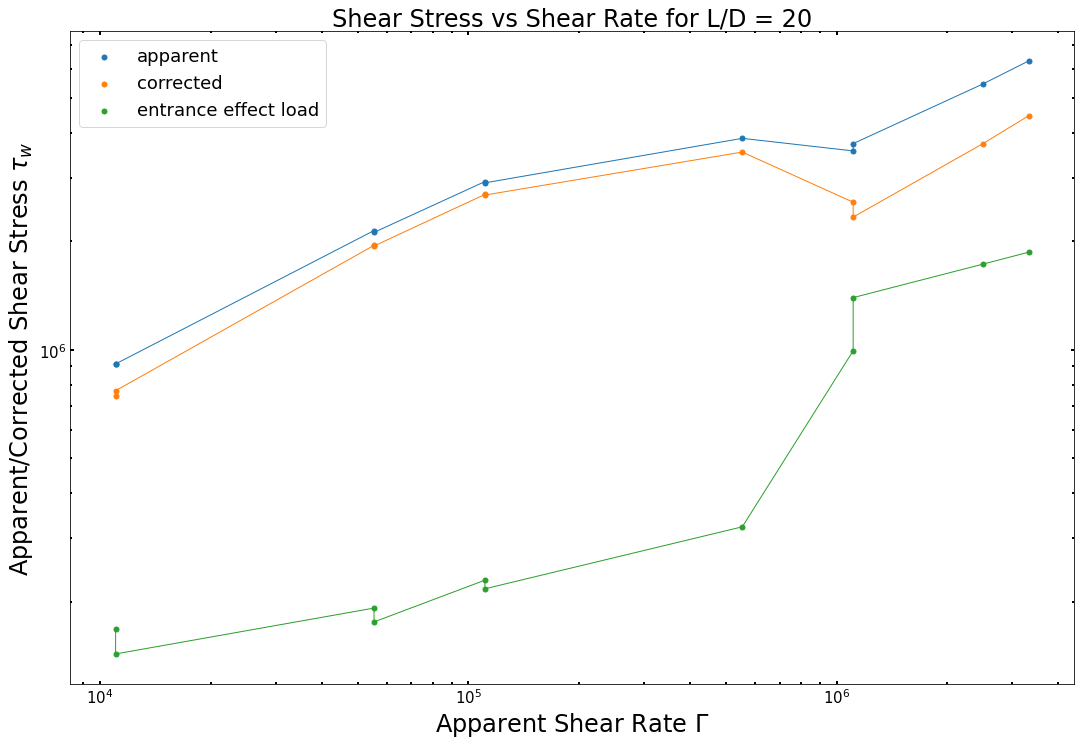

In [17]:
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()

tau_LD20 = _tau_w(avgLoad_LD20 - entrancePressure, 1);

plt.scatter(Gamma, tau_w_LD20,                  s=25, label="apparent", linestyle='-');
plt.scatter(Gamma, tau_LD20,                    s=25, label="corrected", linestyle='-');
plt.scatter(Gamma, _tau_w(entrancePressure, 1), s=25, label="entrance effect load", linestyle='-');

plt.plot(Gamma, tau_w_LD20,                  linewidth=1);
plt.plot(Gamma, tau_LD20,                    linewidth=1);
plt.plot(Gamma, _tau_w(entrancePressure, 1), linewidth=1);

ax0.tick_params(which='both', direction='in', width=2,
                bottom=True, top=True,
                left=True, right=True);

# Display plots
plt.yscale('log');
plt.xscale('log');
plt.xlabel("Apparent Shear Rate " + r'$\Gamma$', fontsize=24);
plt.ylabel("Apparent/Corrected Shear Stress " + r'$\tau_w$', fontsize=24);
plt.title("Shear Stress vs Shear Rate for L/D = 20", size=24);
plt.legend(prop={'size': 18});
plt.savefig('plt_' + "Capillary rheometer correction" + '.png', dpi=300, bbox_inches='tight');
display(plt);

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

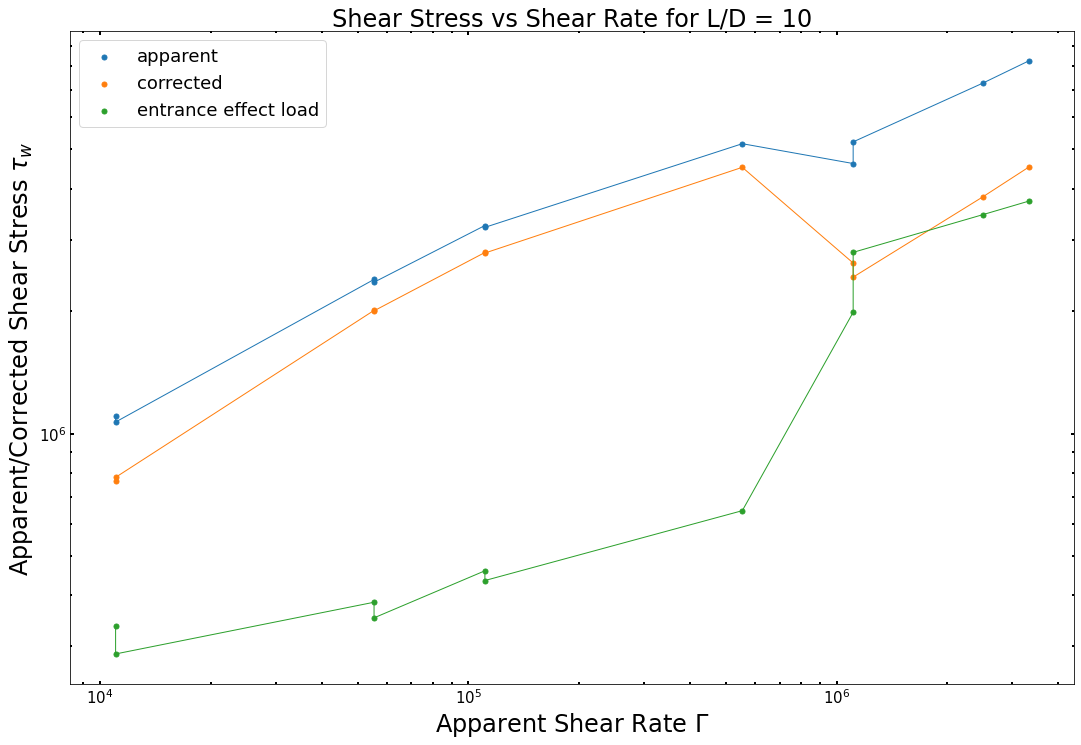

In [18]:
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()

tau_LD10 = _tau_w(avgLoad_LD10 - entrancePressure, 0.5);

plt.scatter(Gamma, tau_w_LD10,                    s=25, label="apparent", linestyle='-');
plt.scatter(Gamma, tau_LD10,                      s=25, label="corrected", linestyle='-');
plt.scatter(Gamma, _tau_w(entrancePressure, 0.5), s=25, label="entrance effect load", linestyle='-');

plt.plot(Gamma, tau_w_LD10,                    linewidth=1);
plt.plot(Gamma, tau_LD10,                      linewidth=1);
plt.plot(Gamma, _tau_w(entrancePressure, 0.5), linewidth=1);

ax0.tick_params(which='both', direction='in', width=2,
                bottom=True, top=True,
                left=True, right=True);

# Display plots
plt.yscale('log');
plt.xscale('log');
plt.xlabel("Apparent Shear Rate " + r'$\Gamma$', fontsize=24);
plt.ylabel("Apparent/Corrected Shear Stress " + r'$\tau_w$', fontsize=24);
plt.title("Shear Stress vs Shear Rate for L/D = 10", size=24);
plt.legend(prop={'size': 18});
plt.savefig('plt_' + "Capillary rheometer correction" + '.png', dpi=300, bbox_inches='tight');
display(plt);

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

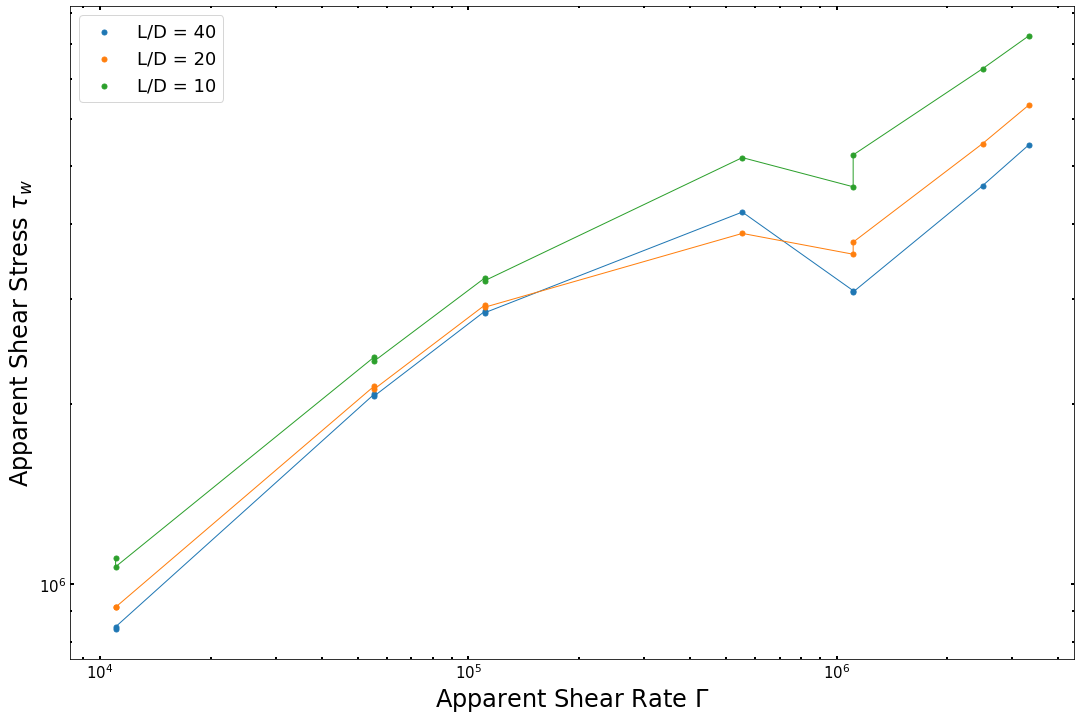

In [19]:
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()

tau_LD10 = _tau_w(avgLoad_LD10 - entrancePressure, 0.5);

plt.scatter(Gamma, tau_w_LD40, s=25, label="L/D = 40", linestyle='-');
plt.scatter(Gamma, tau_w_LD20, s=25, label="L/D = 20", linestyle='-');
plt.scatter(Gamma, tau_w_LD10, s=25, label="L/D = 10", linestyle='-');

plt.plot(Gamma, tau_w_LD40, linewidth=1);
plt.plot(Gamma, tau_w_LD20, linewidth=1);
plt.plot(Gamma, tau_w_LD10, linewidth=1);

ax0.tick_params(which='both', direction='in', width=2,
                bottom=True, top=True,
                left=True, right=True);

# Display plots
plt.yscale('log');
plt.xscale('log');
plt.xlabel("Apparent Shear Rate " + r'$\Gamma$', fontsize=24);
plt.ylabel("Apparent Shear Stress " + r'$\tau_w$', fontsize=24);
#plt.title("Apparent Shear Rate vs Apparent Shear Rate for L/D = 10", size=24);
plt.legend(prop={'size': 18});
plt.savefig('plt_' + "Capillary rheometer correction" + '.png', dpi=300, bbox_inches='tight');
display(plt);

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

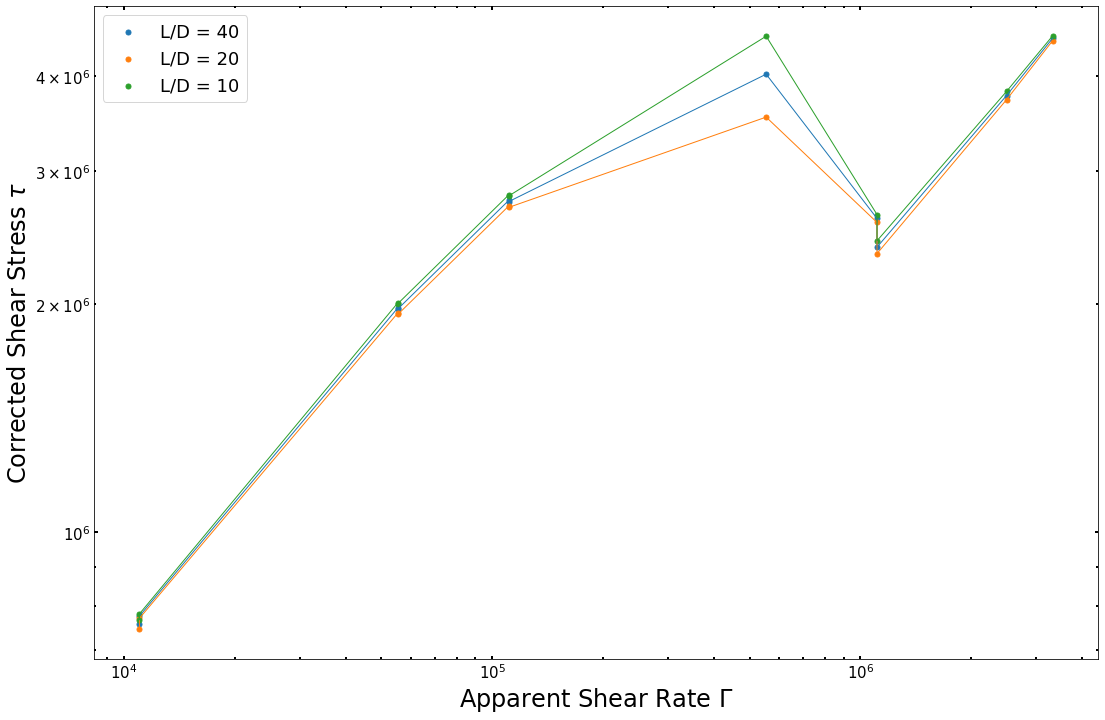

In [20]:
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()

tau_LD10 = _tau_w(avgLoad_LD10 - entrancePressure, 0.5);

plt.scatter(Gamma, tau_LD40, s=25, label="L/D = 40", linestyle='-');
plt.scatter(Gamma, tau_LD20, s=25, label="L/D = 20", linestyle='-');
plt.scatter(Gamma, tau_LD10, s=25, label="L/D = 10", linestyle='-');

plt.plot(Gamma, tau_LD40, linewidth=1);
plt.plot(Gamma, tau_LD20, linewidth=1);
plt.plot(Gamma, tau_LD10, linewidth=1);

ax0.tick_params(which='both', direction='in', width=2,
                bottom=True, top=True,
                left=True, right=True);

# Display plots
plt.yscale('log');
plt.xscale('log');
plt.xlabel("Apparent Shear Rate " + r'$\Gamma$', fontsize=24);
plt.ylabel("Corrected Shear Stress " + r'$\tau$', fontsize=24);
#plt.title("Corrected Shear Rate vs Apparent Shear Rate for L/D = 10", size=24);
plt.legend(prop={'size': 18});
plt.savefig('plt_' + "Capillary rheometer correction" + '.png', dpi=300, bbox_inches='tight');
display(plt);

---
## Rabinowitch Correction:

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

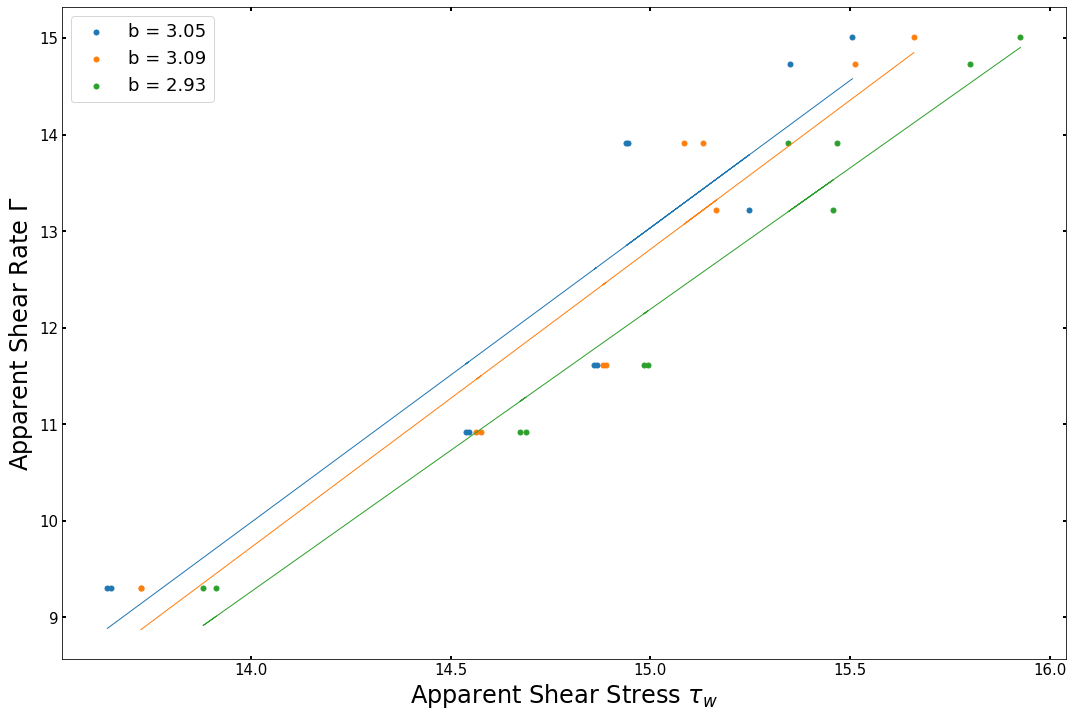

In [21]:
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()

b = [];
tau_w_LD = [tau_w_LD40, tau_w_LD20, tau_w_LD10];
for i in range(len(tau_w_LD)):
    x = np.log(tau_w_LD[i]);
    y = np.log(Gamma);    
    model = LinearRegression().fit(np.array(x).reshape((-1, 1)), np.array(y));
    plt.scatter(x, y, s=25, label="b = " + str(round(model.coef_[0], 2)));
    plt.plot(x, model.predict(np.array(x).reshape((-1, 1))), linewidth=1);
    
    b = b + model.coef_;
#entrancePressure = pd.Series(entrancePressure)

#print("pressures at the entrance when L/D = 0")
#print(entrancePressure)
#print(Gamma)
    
ax0.tick_params(which='both', direction='in', width=2,
                bottom=True, top=True,
                left=True, right=True);

# Display plots
plt.yscale('linear');
plt.xscale('linear');
plt.xlabel("Apparent Shear Stress " + r'$\tau_w$', fontsize=24);
plt.ylabel("Apparent Shear Rate " + r'$\Gamma$', fontsize=24);
# plt.title(plotname, size=24);
plt.legend(prop={'size': 18});
plt.savefig('plt_' + "Capillary rheometer correction" + '.png', dpi=300, bbox_inches='tight');
display(plt);

In [22]:
# Shear rate Gamma
gamma_dot = _gamma_dot(Gamma, 3);

# Real shear viscosity eta
eta_LD40 = _eta_A(tau_LD40, gamma_dot);
eta_LD20 = _eta_A(tau_LD20, gamma_dot);
eta_LD10 = _eta_A(tau_LD10, gamma_dot);

# Create dataframe
Gamma     = Gamma.append(Gamma).append(Gamma);
gamma_dot = gamma_dot.append(gamma_dot).append(gamma_dot);
eta_A     = eta_A_LD40.append(eta_A_LD20).append(eta_A_LD10);
eta       = eta_LD40.append(eta_LD20).append(eta_LD10);

---

           Gamma     gamma_dot       eta_A        eta
0   1.101606e+04  1.652410e+04   76.273005  45.757831
1   1.101606e+04  1.652410e+04   76.900029  46.922305
1   1.101606e+04  1.652410e+04   96.920013  47.235817
0   1.101606e+04  1.652410e+04  100.144709  46.399785
0   1.101606e+04  1.652410e+04   82.946333  45.115878
1   1.101606e+04  1.652410e+04   82.946333  46.608793
2   5.544151e+04  8.316226e+04   37.420852  23.790347
3   5.544151e+04  8.316226e+04   37.153878  23.710255
3   5.544151e+04  8.316226e+04   42.502256  24.098851
2   5.544151e+04  8.316226e+04   43.178590  24.158178
2   5.544151e+04  8.316226e+04   38.604436  23.422517
3   5.544151e+04  8.316226e+04   38.159480  23.321660
5   1.108830e+05  1.663245e+05   28.993373  16.712571
4   1.108830e+05  1.663245e+05   29.295944  16.765965
4   1.108830e+05  1.663245e+05   26.385928  16.208287
5   1.108830e+05  1.663245e+05   26.172348  16.140060
4   1.108830e+05  1.663245e+05   25.767438  16.487126
5   1.108830e+05  1.663245e+

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

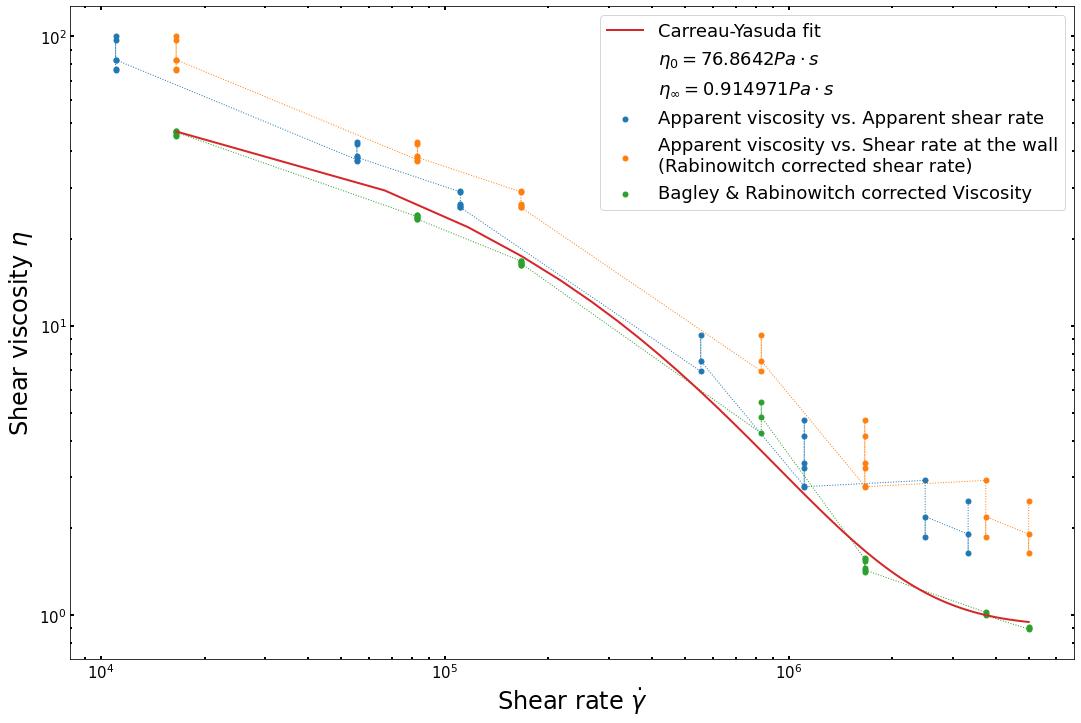

In [25]:
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()

# Define a dictionary containing Students data 
data = {'Gamma': Gamma, 
        'gamma_dot': gamma_dot, 
        'eta_A': eta_A,
        'eta': eta} 
  
# Convert the dictionary into DataFrame 
df = pd.DataFrame(data);
df = df.sort_values('Gamma');

print(df);

plt.scatter(df['Gamma'],     df['eta_A'], s=25, label="Apparent viscosity vs. Apparent shear rate");
plt.scatter(df['gamma_dot'], df['eta_A'], s=25, label="Apparent viscosity vs. Shear rate at the wall\n(Rabinowitch corrected shear rate)");
plt.scatter(df['gamma_dot'], df['eta'],   s=25, label="Bagley & Rabinowitch corrected Viscosity");

plt.plot(df['Gamma'],     df['eta_A'], linewidth=1, linestyle=':');
plt.plot(df['gamma_dot'], df['eta_A'], linewidth=1, linestyle=':');
plt.plot(df['gamma_dot'], df['eta'],   linewidth=1, linestyle=':');

x = np.linspace(min(df['gamma_dot']), max(df['gamma_dot']), 100);
y = CarreauYasuda_(x, 76.8642, 0.914971, 2.17427e-11, -306.698, 0.481699)
plt.plot(x, y, linewidth=2, linestyle='-', label="Carreau-Yasuda fit");
plt.plot(x[0], y[0], linewidth=0, linestyle=':', label=r'$\eta_0 = 76.8642 Pa \cdot s$');
plt.plot(x[0], y[0], linewidth=0, linestyle=':', label=r'$\eta_{\infty} = 0.914971 Pa \cdot s$');

ax0.tick_params(which='both', direction='in', width=2,
                bottom=True, top=True,
                left=True, right=True);

# Display plots
plt.yscale('log');
plt.xscale('log');
plt.xlabel("Shear rate " + r'$\dot{\gamma}$', fontsize=24);
plt.ylabel("Shear viscosity " + r'$\eta$', fontsize=24);
# plt.title(plotname, size=24);
plt.legend(prop={'size': 18});
plt.savefig('plt_' + "Capillary rheometer correction" + '.png', dpi=300, bbox_inches='tight');
display(plt);